In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import copy
import math
import random
import time
import re
import graphviz
import ast
import sys
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

In [2]:
data_train = pd.read_csv('train.csv')
data_train.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


In [3]:
data_test = pd.read_csv('test.csv')
data_test.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal


In [4]:
data_test['SalePrice'] = -1
full_data = data_train.append(data_test, ignore_index=True, sort=False)
full_data.shape

(2919, 81)

In [5]:
#Define useful filters:
train_mask = full_data['SalePrice'] > 0
test_mask = full_data['SalePrice'] < 0

In [6]:
miss_val = pd.DataFrame(full_data.isna().any()[full_data.isna().any()==True].index, columns = ['miss'])
miss_val['miss count'] = miss_val['miss'].apply(lambda x: full_data[x].isna().sum())
miss_val.head()

,miss,miss count
0,MSZoning,4
1,LotFrontage,486
2,Alley,2721
3,Utilities,2
4,Exterior1st,1


In [7]:
full_data[full_data['MSZoning'].isna()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1915,1916,30,NaN,109.0,21780,Grvl,NaN,Reg,Lvl,NaN,...,0,NaN,NaN,NaN,0,3,2009,ConLD,Normal,-1
2216,2217,20,NaN,80.0,14584,Pave,NaN,Reg,Low,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Abnorml,-1
2250,2251,70,NaN,NaN,56600,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,-1
2904,2905,20,NaN,125.0,31250,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,-1


In [8]:
full_data.groupby('MSZoning').count()

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
MSZoning,,,,,,,,,,,,,,,,,,,,,
C (all),25,25,23,25,25,3,25,25,25,25,...,25,0,3,2,25,25,25,25,25,25
FV,139,139,119,139,139,52,139,139,139,139,...,139,0,2,0,139,139,139,139,139,139
RH,26,26,23,26,26,4,26,26,26,26,...,26,0,3,1,26,26,26,26,26,26
RL,2265,2265,1839,2265,2265,40,2265,2265,2264,2265,...,2265,10,456,91,2265,2265,2265,2264,2265,2265
RM,460,460,426,460,460,99,460,460,460,460,...,460,0,107,11,460,460,460,460,460,460


In [9]:
full_data[full_data['MSZoning'].isna()][['YearBuilt', 'Utilities', 'BldgType', 'HouseStyle', 'RoofStyle', 'BedroomAbvGr', 'GarageCars']]

,YearBuilt,Utilities,BldgType,HouseStyle,RoofStyle,BedroomAbvGr,GarageCars
1915,1910,NaN,1Fam,1Story,Gable,1,1.0
2216,1952,AllPub,1Fam,1Story,Gable,2,2.0
2250,1900,AllPub,1Fam,2.5Unf,Hip,4,1.0
2904,1951,AllPub,1Fam,1Story,Gable,3,1.0


In [10]:
full_data[full_data['YearBuilt'] < 1953].groupby('MSZoning').count()

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
MSZoning,,,,,,,,,,,,,,,,,,,,,
C (all),24,24,22,24,24,3,24,24,24,24,...,24,0,3,2,24,24,24,24,24,24
RH,15,15,13,15,15,3,15,15,15,15,...,15,0,0,0,15,15,15,15,15,15
RL,357,357,323,357,357,38,357,357,356,357,...,357,1,96,19,357,357,357,357,357,357
RM,306,306,289,306,306,92,306,306,306,306,...,306,0,89,10,306,306,306,306,306,306


In [11]:
mask =((full_data['BldgType'] == '1Fam') & (full_data['Utilities'] == 'AllPub') & (full_data['HouseStyle'] == '1Story'))
mask2 = mask & (full_data['YearBuilt'] < 1953)
mask3 = mask2 & (full_data['SalePrice'] > 0)

/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:195: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0, 500000)

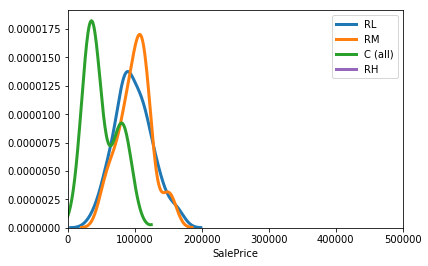

In [12]:
for zone in full_data['MSZoning'].unique():
    subset = data_train[(data_train['MSZoning'] == zone) & (data_train['YearBuilt'] < 1950)&(data_train['HouseStyle'] == '1Story')]
    sns.distplot(subset['SalePrice'], hist=False, kde=True
                , kde_kws={'linewidth':3}, label=zone)  
plt.xlim(0,500000)

/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:195: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0, 5e-05)

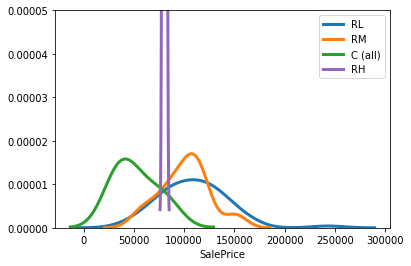

In [13]:
for zone in full_data['MSZoning'].unique():
    subset = full_data[mask3 & (full_data['MSZoning'] == zone)]
    sns.distplot(subset['SalePrice'], hist=False, kde=True
                , kde_kws={'linewidth':3}, label=zone)  
#plt.xlim(0,5)
plt.ylim(0,0.00005)

Nothing to lose if we fill 'MSZoning' with RL

In [14]:
full_data[full_data['Utilities'].isna()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1915,1916,30,NaN,109.0,21780,Grvl,NaN,Reg,Lvl,NaN,...,0,NaN,NaN,NaN,0,3,2009,ConLD,Normal,-1
1945,1946,20,RL,NaN,31220,Pave,NaN,IR1,Bnk,NaN,...,0,NaN,NaN,Shed,750,5,2008,WD,Normal,-1


In [15]:
full_data.groupby('Utilities').count()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Utilities,,,,,,,,,,,,,,,,,,,,,
AllPub,2916,2916,2913,2432,2916,2916,198,2916,2916,2916,...,2916,10,571,104,2916,2916,2916,2915,2916,2916
NoSeWa,1,1,1,0,1,1,0,1,1,1,...,1,0,0,0,1,1,1,1,1,1


In [16]:
full_data = full_data.drop(['Utilities'], axis=1)

In [17]:
full_data['Exterior1st'].unique()

array(['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing',
       'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn',
       'Stone', 'ImStucc', 'CBlock', nan], dtype=object)

In [18]:
full_data[full_data['Exterior1st'].isna()][['Exterior2nd', 'SalePrice']]

,Exterior2nd,SalePrice
2151,NaN,-1


In [19]:
full_data.groupby('Exterior1st').count()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Exterior1st,,,,,,,,,,,,,,,,,,,,,
AsbShng,44,44,43,42,44,44,10,44,44,44,...,44,0,16,0,44,44,44,44,44,44
AsphShn,2,2,2,2,2,2,1,2,2,2,...,2,0,0,0,2,2,2,2,2,2
BrkComm,6,6,6,6,6,6,0,6,6,6,...,6,0,2,0,6,6,6,6,6,6
BrkFace,87,87,87,74,87,87,4,87,87,87,...,87,0,23,4,87,87,87,87,87,87
CBlock,2,2,1,2,2,2,0,2,2,2,...,2,0,0,0,2,2,2,2,2,2
CemntBd,126,126,126,116,126,126,6,126,126,126,...,126,0,11,1,126,126,126,126,126,126
HdBoard,442,442,442,327,442,442,4,442,442,442,...,442,1,129,31,442,442,442,442,442,442
ImStucc,1,1,1,1,1,1,0,1,1,1,...,1,0,1,0,1,1,1,1,1,1
MetalSd,450,450,450,398,450,450,70,450,450,450,...,450,1,110,17,450,450,450,450,450,450


In [20]:
def showCategor(feature, toShow):
    for val in full_data[feature].unique():
        subset = full_data[(full_data['SalePrice'] > 0) & (full_data[feature] == val)]
        sns.distplot(subset[toShow], hist=False, kde=True
                    , kde_kws={'linewidth':3}, label=val)  

In [21]:
full_data[full_data['Exterior1st'].isna()][['BldgType','HouseStyle' ,'YearBuilt', 'RoofStyle', 'Foundation']]

,BldgType,HouseStyle,YearBuilt,RoofStyle,Foundation
2151,1Fam,1Story,1940,Flat,PConc


In [22]:
mask = ((full_data['BldgType'] == '1Fam') 
        & (full_data['HouseStyle'] == '1Story') 
        & (full_data['YearBuilt'] > 1930) 
        & (full_data['YearBuilt'] < 1960) 
        & (full_data['RoofStyle'] == 'Flat') )
#        & (full_data['Foundation'] == 'PConc'))

In [23]:
full_data[(full_data['RoofStyle'] == 'Flat') & (full_data['YearBuilt'] < 1970) & (full_data['HouseStyle'] == '1Story') & (full_data['BldgType'] == '1Fam')].shape

(11, 80)

In [24]:
full_data[(full_data['YearBuilt'] < 1941) & (full_data['Foundation'] == 'PConc')].groupby('Exterior1st').count()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Exterior1st,,,,,,,,,,,,,,,,,,,,,
AsbShng,4,4,4,4,4,4,0,4,4,4,...,4,0,4,0,4,4,4,4,4,4
AsphShn,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,1,1,1,1,1,1
BrkFace,4,4,4,3,4,4,0,4,4,4,...,4,0,0,0,4,4,4,4,4,4
CBlock,1,1,1,1,1,1,0,1,1,1,...,1,0,0,0,1,1,1,1,1,1
CemntBd,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,1,1,1,1,1,1
HdBoard,2,2,2,2,2,2,0,2,2,2,...,2,0,0,0,2,2,2,2,2,2
MetalSd,23,23,23,23,23,23,6,23,23,23,...,23,0,5,1,23,23,23,23,23,23
Plywood,1,1,1,1,1,1,0,1,1,1,...,1,0,0,0,1,1,1,1,1,1
Stucco,9,9,9,7,9,9,2,9,9,9,...,9,1,6,0,9,9,9,9,9,9


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


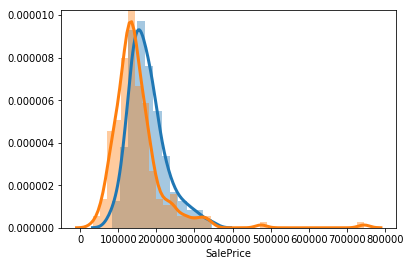

In [25]:
for zone in ['Plywood', 'Wd Sdng']:
    subset = full_data[(full_data['Exterior1st'] == zone) & (full_data['SalePrice'] > 0)]
    sns.distplot(subset['SalePrice'], hist=True, kde=True
                , kde_kws={'linewidth':3}, label=zone)  

In [26]:
full_data[full_data['Exterior1st'] == 'Wd Sdng'].groupby('Exterior2nd').count()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Exterior2nd,,,,,,,,,,,,,,,,,,,,,
AsbShng,1,1,1,1,1,1,0,1,1,1,...,1,0,0,0,1,1,1,1,1,1
BrkFace,1,1,1,1,1,1,0,1,1,1,...,1,0,0,0,1,1,1,1,1,1
HdBoard,7,7,7,5,7,7,2,7,7,7,...,7,0,2,2,7,7,7,7,7,7
ImStucc,3,3,3,3,3,3,0,3,3,3,...,3,1,1,0,3,3,3,3,3,3
MetalSd,4,4,4,3,4,4,0,4,4,4,...,4,0,0,1,4,4,4,4,4,4
Plywood,17,17,17,11,17,17,0,17,17,17,...,17,0,7,2,17,17,17,17,17,17
Stone,1,1,1,0,1,1,0,1,1,1,...,1,0,0,0,1,1,1,1,1,1
Stucco,3,3,3,2,3,3,0,3,3,3,...,3,0,1,0,3,3,3,3,3,3
VinylSd,3,3,3,3,3,3,1,3,3,3,...,3,0,0,1,3,3,3,3,3,3


In [27]:
full_data = full_data.fillna({'Exterior1st':'Wd Sdng', 'Exterior2nd' : 'Wd Sdng', 'MSZoning' : 'RL'})

In [28]:
miss_val = pd.DataFrame(full_data.isna().any()[full_data.isna().any()==True].index, columns = ['miss'])
miss_val['miss count'] = miss_val['miss'].apply(lambda x: full_data[x].isna().sum())
miss_val.head()

,miss,miss count
0,LotFrontage,486
1,Alley,2721
2,MasVnrType,24
3,MasVnrArea,23
4,BsmtQual,81


In [29]:
masVnr_mask = (full_data['MasVnrType'].isna()) | (full_data['MasVnrArea'].isna())
full_data[masVnr_mask].shape

(24, 80)

In [30]:
full_data[masVnr_mask]["MasVnrArea"]

234       NaN
529       NaN
650       NaN
936       NaN
973       NaN
977       NaN
1243      NaN
1278      NaN
1691      NaN
1706      NaN
1882      NaN
1992      NaN
2004      NaN
2041      NaN
2311      NaN
2325      NaN
2340      NaN
2349      NaN
2368      NaN
2592      NaN
2610    198.0
2657      NaN
2686      NaN
2862      NaN
Name: MasVnrArea, dtype: float64

In [31]:
full_data.groupby('MasVnrType').count()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
MasVnrType,,,,,,,,,,,,,,,,,,,,,
BrkCmn,25,25,25,18,25,25,0,25,25,25,...,25,0,11,2,25,25,25,25,25,25
BrkFace,879,879,879,679,879,879,17,879,879,879,...,879,3,146,25,879,879,879,878,879,879
None,1742,1742,1742,1488,1742,1742,169,1742,1742,1742,...,1742,5,400,76,1742,1742,1742,1742,1742,1742
Stone,249,249,249,230,249,249,10,249,249,249,...,249,2,14,2,249,249,249,249,249,249


/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:195: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


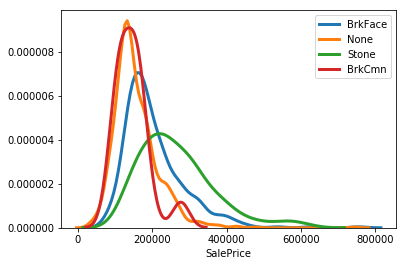

In [32]:
showCategor('MasVnrType', 'SalePrice')

In [33]:
full_data.iloc[2610][0:20]

Id                 2611
MSSubClass           20
MSZoning             RL
LotFrontage         124
LotArea           27697
Street             Pave
Alley               NaN
LotShape            Reg
LandContour         Lvl
LotConfig        Inside
LandSlope           Gtl
Neighborhood    Mitchel
Condition1         Norm
Condition2         Norm
BldgType           1Fam
HouseStyle       1Story
OverallQual           4
OverallCond           3
YearBuilt          1961
YearRemodAdd       1961
Name: 2610, dtype: object

In [34]:
full_data = full_data.fillna({'MasVnrType':'None', 'MasVnrArea' : 0})

In [35]:
miss_val = pd.DataFrame(full_data.isna().any()[full_data.isna().any()==True].index, columns = ['miss'])
miss_val['miss count'] = miss_val['miss'].apply(lambda x: full_data[x].isna().sum())
miss_val.head()

,miss,miss count
0,LotFrontage,486
1,Alley,2721
2,BsmtQual,81
3,BsmtCond,82
4,BsmtExposure,82


In [36]:
full_data['Alley'].unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

In [37]:
full_data.groupby(['Alley', 'Street']).count()['SalePrice']

Alley  Street
Grvl   Pave      120
Pave   Pave       78
Name: SalePrice, dtype: int64

In [38]:
full_data[full_data['SalePrice'] > 0].groupby('Alley').describe()['SalePrice']

,count,mean,std,min,25%,50%,75%,max
Alley,,,,,,,,
Grvl,50.0,122219.080000,34780.780734,52500.0,105312.5,119500.0,136750.0,256000.0
Pave,41.0,168000.585366,38370.375243,40000.0,151000.0,172500.0,185000.0,265979.0


In [39]:
full_data = full_data.drop(['Alley'], axis=1)
full_data.shape

(2919, 79)

In [40]:
miss_val = pd.DataFrame(full_data.isna().any()[full_data.isna().any()==True].index, columns = ['miss'])
miss_val['miss count'] = miss_val['miss'].apply(lambda x: full_data[x].isna().sum())
miss_val.head()

,miss,miss count
0,LotFrontage,486
1,BsmtQual,81
2,BsmtCond,82
3,BsmtExposure,82
4,BsmtFinType1,79


In [41]:
f_bsmt = ['BsmtQual','BsmtCond' ,'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1'
          , 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
full_data[f_bsmt].head()

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
0,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,1.0,0.0
1,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,0.0,1.0
2,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,1.0,0.0
3,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,1.0,0.0
4,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,1.0,0.0


In [42]:
full_data[full_data['TotalBsmtSF']==0][f_bsmt].head()

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
17,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
39,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
90,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
102,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
156,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0


In [43]:
full_data[full_data['BsmtFullBath'].isna()][f_bsmt]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
2120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2188,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN


In [44]:
full_data = full_data.fillna({'TotalBsmtSF': 0})

In [45]:
full_data.loc[full_data['TotalBsmtSF'] == 0,['BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1'
                                          , 'BsmtFinType2']] = full_data[full_data['TotalBsmtSF'] == 0][['BsmtQual'
                                                                    ,'BsmtCond', 'BsmtExposure', 'BsmtFinType1'
                                                                      , 'BsmtFinType2']].fillna('None')

In [46]:
full_data.loc[full_data['TotalBsmtSF'] == 0
              ,['BsmtFinSF1', 'BsmtFinSF2'
                , 'BsmtUnfSF', 'BsmtFullBath'
                , 'BsmtHalfBath']] = full_data[full_data['TotalBsmtSF'] == 0][['BsmtFinSF1', 'BsmtFinSF2'
                                                                            , 'BsmtUnfSF', 'BsmtFullBath'
                                                                            , 'BsmtHalfBath']].fillna(0)

In [47]:
full_data['BsmtFinType1'].unique()

array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', 'None', 'LwQ'], dtype=object)

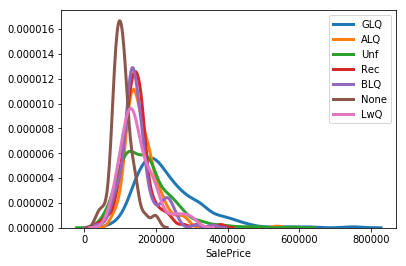

In [48]:
showCategor('BsmtFinType1', 'SalePrice')

In [49]:
miss_val = pd.DataFrame(full_data.isna().any()[full_data.isna().any()==True].index, columns = ['miss'])
miss_val['miss count'] = miss_val['miss'].apply(lambda x: full_data[x].isna().sum())
miss_val.head()

,miss,miss count
0,LotFrontage,486
1,BsmtQual,2
2,BsmtCond,3
3,BsmtExposure,3
4,BsmtFinType2,1


In [50]:
full_data[full_data['BsmtQual'].isna()].transpose()[60:80]

,2217,2218
GarageArea,185,195
GarageQual,Fa,Po
GarageCond,TA,Fa
PavedDrive,Y,N
WoodDeckSF,0,0
OpenPorchSF,123,0
EnclosedPorch,0,0
3SsnPorch,0,0
ScreenPorch,0,0
PoolArea,0,0


In [51]:
full_data[train_mask & (full_data['OverallCond'] == 7) ].groupby(['BsmtQual', 'OverallQual']).describe()['SalePrice']

count           mean           std       min        25%  \
BsmtQual OverallQual                                                            
Ex       5              1.0  123500.000000           NaN  123500.0  123500.00   
         6              1.0  191000.000000           NaN  191000.0  191000.00   
Fa       4              4.0  106742.750000  15526.870588   89471.0   97367.75   
         5              4.0  117937.500000  22927.762465   85000.0  111062.50   
         6              1.0  163000.000000           NaN  163000.0  163000.00   
         7              1.0  157000.000000           NaN  157000.0  157000.00   
Gd       4              3.0   98166.666667  25934.211639   81000.0   83250.00   
         5             13.0  139561.538462  27262.261415   92000.0  129500.00   
         6             17.0  200977.647059  45873.961096  145000.0  161750.00   
         7             11.0  227663.636364  33215.546743  163000.0  200200.00   
         8              6.0  290166.666667  84196.001489  164000.0  245000.00   
None     4              2.0   95575.000000  15096.729778   84900.0   90237.50   
         5              3.0  107833.333333   1527.525232  106500.0  107000.00   
TA       3              1.0  120000.000000           NaN  120000.0  120000.00   
         4             10.0  110042.600000  18583.028483   82500.0   98069.00   
         5             68.0  132942.647059  20821.804847   87000.0  119000.00   
         6             47.0  168489.978723  43465.198828   79900.0  136750.00   
         7             11.0  205516.272727  58923.116455  116900.0  159750.00   
         8              1.0  161000.000000           NaN  161000.0  161000.00   

                           50%       75%       max  
BsmtQual OverallQual                                
Ex       5            123500.0  123500.0  123500.0  
         6            191000.0  191000.0  191000.0  
Fa       4            106000.0  115375.0  125500.0  
         5            125875.0  132750.0  135000.0  
         6            163000.0  163000.0  163000.0  
         7            157000.0  157000.0  157000.0  
Gd       4             85500.0  106750.0  128000.0  
         5            133000.0  150500.0  194000.0  
         6            182900.0  235000.0  277000.0  
         7            241500.0  246000.0  271900.0  
         8            300000.0  336250.0  402000.0  
None     4             95575.0  100912.5  106250.0  
         5            107500.0  108500.0  109500.0  
TA       3            120000.0  120000.0  120000.0  
         4            108900.0  123775.0  135750.0  
         5            132750.0  146625.0  197500.0  
         6            158000.0  198750.0  257500.0  
         7            205000.0  253450.0  294000.0  
         8            161000.0  161000.0  161000.0

In [52]:
full_data=full_data.fillna({'BsmtQual': 'TA'})

In [53]:
miss_val = pd.DataFrame(full_data.isna().any()[full_data.isna().any()==True].index, columns = ['miss'])
miss_val['miss count'] = miss_val['miss'].apply(lambda x: full_data[x].isna().sum())
miss_val.head()

,miss,miss count
0,LotFrontage,486
1,BsmtCond,3
2,BsmtExposure,3
3,BsmtFinType2,1
4,Electrical,1


In [54]:
full_data[full_data['BsmtCond'].isna()].transpose()[15:35]

,2040,2185,2524
OverallQual,8,6,5
OverallCond,9,6,7
YearBuilt,1976,1976,1977
YearRemodAdd,2007,1976,1977
RoofStyle,Gable,Hip,Gable
RoofMatl,CompShg,CompShg,CompShg
Exterior1st,VinylSd,HdBoard,Plywood
Exterior2nd,VinylSd,Plywood,VinylSd
MasVnrType,None,BrkFace,BrkFace
MasVnrArea,0,84,51


In [55]:
full_data['BsmtCond'].unique()

array(['TA', 'Gd', 'None', 'Fa', 'Po', nan], dtype=object)

In [56]:
full_data[train_mask].groupby(['OverallCond', 'BsmtCond']).describe()['SalePrice']

count           mean            std       min  \
OverallCond BsmtCond                                                  
1           Po          1.0   61000.000000            NaN   61000.0   
2           Fa          2.0   86000.000000    1414.213562   85000.0   
            Po          1.0   67000.000000            NaN   67000.0   
            TA          2.0  235466.000000  224811.873156   76500.0   
3           Fa          7.0   84842.857143   30273.027442   58500.0   
            None        4.0   75825.000000   25369.059239   39300.0   
            TA         14.0  117931.071429   49998.645813   35311.0   
4           Fa          7.0  106114.285714   34935.484757   55000.0   
            None        5.0  104666.400000   19688.805063   87500.0   
            TA         45.0  124419.088889   40612.161771   40000.0   
5           Fa          8.0  121212.500000   43268.478711   60000.0   
            Gd         38.0  224568.263158   69790.845062  127500.0   
            None       20.0  110318.750000   30446.230116   55000.0   
            TA        755.0  205395.957616   85272.432022   34900.0   
6           Fa          7.0  131185.714286   29090.171798   95000.0   
            Gd          6.0  168700.000000   51944.393345  128200.0   
            None        3.0  120500.000000   48251.942966   72500.0   
            TA        236.0  154687.800847   61689.728543   37900.0   
7           Fa         10.0  154222.900000   50148.792050   96500.0   
            Gd         11.0  212727.272727   88999.821246  123500.0   
            None        5.0  102930.000000   10159.945866   84900.0   
            TA        179.0  156552.770950   49282.810014   79900.0   
8           Fa          4.0  135625.000000   35368.005787  110000.0   
            Gd          6.0  188650.000000   72411.428656  119000.0   
            TA         62.0  153750.403226   50640.580276   84500.0   
9           Gd          4.0  216575.000000   78173.668841  145000.0   
            TA         18.0  215877.777778  102085.734185  110500.0   

                            25%       50%        75%       max  
OverallCond BsmtCond                                            
1           Po         61000.00   61000.0   61000.00   61000.0  
2           Fa         85500.00   86000.0   86500.00   87000.0  
            Po         67000.00   67000.0   67000.00   67000.0  
            TA        155983.00  235466.0  314949.00  394432.0  
3           Fa         60000.00   76000.0  100750.00  137900.0  
            None       71325.00   83000.0   87500.00   98000.0  
            TA         82000.00  105300.0  154875.00  200624.0  
4           Fa         86500.00  104900.0  124950.00  160000.0  
            None       92900.00   93500.0  115000.00  134432.0  
            TA         93000.00  119000.0  149900.00  235000.0  
5           Fa         97250.00  118850.0  136750.00  184000.0  
            Gd        179166.25  204400.0  262670.75  465000.0  
            None       92250.00  104900.0  120723.00  198500.0  
            TA        145000.00  186500.0  240000.00  745000.0  
6           Fa        118500.00  127500.0  134900.00  189000.0  
            Gd        135000.00  154500.0  172500.00  268000.0  
            None       96250.00  120000.0  144500.00  169000.0  
            TA        124800.00  143375.0  173250.00  755000.0  
7           Fa        122812.50  151000.0  163750.00  265979.0  
            Gd        145750.00  178000.0  257500.00  402000.0  
            None      106250.00  106500.0  107500.00  109500.0  
            TA        124700.00  145000.0  177750.00  345000.0  
8           Fa        115250.00  122500.0  142875.00  187500.0  
            Gd        140975.00  167450.0  215000.00  315000.0  
            TA        125668.75  142500.0  165625.00  335000.0  
9           Gd        152500.00  210750.0  274825.00  299800.0  
            TA        140750.00  176200.0  279750.00  475000.0

In [57]:
full_data=full_data.fillna({'BsmtCond': 'TA'})

In [58]:
miss_val = pd.DataFrame(full_data.isna().any()[full_data.isna().any()==True].index, columns = ['miss'])
miss_val['miss count'] = miss_val['miss'].apply(lambda x: full_data[x].isna().sum())
miss_val.head(10)

,miss,miss count
0,LotFrontage,486
1,BsmtExposure,3
2,BsmtFinType2,1
3,Electrical,1
4,KitchenQual,1
5,Functional,2
6,FireplaceQu,1420
7,GarageType,157
8,GarageYrBlt,159
9,GarageFinish,159


In [59]:
full_data[full_data['BsmtExposure'].isna()].transpose()[20:40]

,948,1487,2348
RoofMatl,CompShg,CompShg,CompShg
Exterior1st,VinylSd,VinylSd,VinylSd
Exterior2nd,VinylSd,VinylSd,VinylSd
MasVnrType,BrkFace,BrkFace,None
MasVnrArea,144,226,0
ExterQual,Gd,Gd,Gd
ExterCond,TA,TA,TA
Foundation,PConc,PConc,CBlock
BsmtQual,Gd,Gd,Gd
BsmtCond,TA,TA,TA


In [60]:
full_data['BsmtExposure'].unique()

array(['No', 'Gd', 'Mn', 'Av', 'None', nan], dtype=object)

In [61]:
full_data[train_mask & (full_data['TotalBsmtSF'] > 1500)].groupby('BsmtExposure').describe()['TotalBsmtSF']

,count,mean,std,min,25%,50%,75%,max
BsmtExposure,,,,,,,,
Av,50.0,1731.120000,186.720531,1520.0,1589.25,1682.0,1842.5,2396.0
Gd,55.0,1952.745455,671.873175,1502.0,1630.00,1753.0,1994.0,6110.0
Mn,13.0,1784.846154,198.714974,1541.0,1660.00,1763.0,1836.0,2158.0
No,86.0,1733.488372,290.687005,1501.0,1576.25,1653.0,1764.0,3206.0


In [62]:
full_data = full_data.fillna({'BsmtExposure' : 'No'})
full_data.loc[full_data['BsmtExposure'] == 'None', ['BsmtExposure']] = 'No'

In [63]:
full_data['BsmtExposure'].unique()

array(['No', 'Gd', 'Mn', 'Av'], dtype=object)

In [64]:
miss_val = pd.DataFrame(full_data.isna().any()[full_data.isna().any()==True].index, columns = ['miss'])
miss_val['miss count'] = miss_val['miss'].apply(lambda x: full_data[x].isna().sum())
miss_val.head()

,miss,miss count
0,LotFrontage,486
1,BsmtFinType2,1
2,Electrical,1
3,KitchenQual,1
4,Functional,2


In [65]:
full_data['BsmtFinType2'].unique()

array(['Unf', 'BLQ', 'None', 'ALQ', 'Rec', 'LwQ', 'GLQ', nan],
      dtype=object)

In [66]:
full_data[full_data['BsmtFinType2'].isna()].transpose()[20:40]

,332
RoofMatl,CompShg
Exterior1st,VinylSd
Exterior2nd,VinylSd
MasVnrType,BrkFace
MasVnrArea,296
ExterQual,Gd
ExterCond,TA
Foundation,PConc
BsmtQual,Gd
BsmtCond,TA


In [67]:
full_data.groupby(['BsmtFinType1','BsmtFinType2']).count()['SalePrice']

BsmtFinType1  BsmtFinType2
ALQ           BLQ              30
              GLQ               3
              LwQ              27
              Rec              36
              Unf             333
BLQ           ALQ               4
              BLQ               1
              GLQ              10
              LwQ              23
              Rec              34
              Unf             197
GLQ           ALQ              15
              BLQ               7
              LwQ              17
              Rec              19
              Unf             790
LwQ           ALQ              14
              BLQ              11
              GLQ              14
              Rec              16
              Unf              99
None          None             79
Rec           ALQ              19
              BLQ              19
              GLQ               7
              LwQ              20
              Unf             223
Unf           Unf             851
Name: SalePrice, dtyp

In [68]:
full_data = full_data.fillna({'BsmtFinType2':'Unf'})

In [69]:
miss_val = pd.DataFrame(full_data.isna().any()[full_data.isna().any()==True].index, columns = ['miss'])
miss_val['miss count'] = miss_val['miss'].apply(lambda x: full_data[x].isna().sum())
miss_val.head()

,miss,miss count
0,LotFrontage,486
1,Electrical,1
2,KitchenQual,1
3,Functional,2
4,FireplaceQu,1420


In [70]:
full_data['Electrical'].unique()

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', nan], dtype=object)

In [71]:
full_data[full_data['Electrical'].isna()].transpose()[10:20]

,1379
Neighborhood,Timber
Condition1,Norm
Condition2,Norm
BldgType,1Fam
HouseStyle,SLvl
OverallQual,5
OverallCond,5
YearBuilt,2006
YearRemodAdd,2007
RoofStyle,Gable


In [72]:
full_data[train_mask & (full_data['YearBuilt'] > 2005)].groupby('Electrical').describe()['SalePrice']

,count,mean,std,min,25%,50%,75%,max
Electrical,,,,,,,,
SBrkr,157.0,270561.471338,93150.639878,84500.0,202500.0,248328.0,318000.0,611657.0


In [73]:
full_data = full_data.fillna({'Electrical':'SBrkr'})

In [74]:
miss_val = pd.DataFrame(full_data.isna().any()[full_data.isna().any()==True].index, columns = ['miss'])
miss_val['miss count'] = miss_val['miss'].apply(lambda x: full_data[x].isna().sum())
miss_val.head()

,miss,miss count
0,LotFrontage,486
1,KitchenQual,1
2,Functional,2
3,FireplaceQu,1420
4,GarageType,157


In [75]:
full_data['KitchenQual'].unique()

array(['Gd', 'TA', 'Ex', 'Fa', nan], dtype=object)

In [76]:
full_data[full_data['KitchenQual'].isna()].transpose()[10:20]

,1555
Neighborhood,ClearCr
Condition1,Norm
Condition2,Norm
BldgType,1Fam
HouseStyle,1.5Fin
OverallQual,5
OverallCond,3
YearBuilt,1917
YearRemodAdd,1950
RoofStyle,Gable


In [77]:
full_data[train_mask & (full_data['OverallCond'] == 3) ].groupby(['KitchenQual', 'OverallQual']).describe()['SalePrice']

count           mean           std       min  \
KitchenQual OverallQual                                                 
Fa          1              1.0   39300.000000           NaN   39300.0   
            2              1.0   60000.000000           NaN   60000.0   
            3              1.0   82000.000000           NaN   82000.0   
Gd          4              1.0  135000.000000           NaN  135000.0   
TA          2              1.0   35311.000000           NaN   35311.0   
            3              2.0   62750.000000   6010.407640   58500.0   
            4              4.0  111000.000000  28401.877872   84000.0   
            5              7.0   90571.428571  24063.576507   60000.0   
            6              6.0  132687.333333  48425.548656   76000.0   
            7              1.0  197000.000000           NaN  197000.0   

                              25%       50%       75%       max  
KitchenQual OverallQual                                          
Fa          1             39300.0   39300.0   39300.0   39300.0  
            2             60000.0   60000.0   60000.0   60000.0  
            3             82000.0   82000.0   82000.0   82000.0  
Gd          4            135000.0  135000.0  135000.0  135000.0  
TA          2             35311.0   35311.0   35311.0   35311.0  
            3             60625.0   62750.0   64875.0   67000.0  
            4             94500.0  105000.0  121500.0  150000.0  
            5             80500.0   85000.0   95050.0  137900.0  
            6             94625.0  133250.0  161750.0  200624.0  
            7            197000.0  197000.0  197000.0  197000.0

In [78]:
full_data = full_data.fillna({'KitchenQual':'TA'})

In [79]:
miss_val = pd.DataFrame(full_data.isna().any()[full_data.isna().any()==True].index, columns = ['miss'])
miss_val['miss count'] = miss_val['miss'].apply(lambda x: full_data[x].isna().sum())
miss_val.head(5)

,miss,miss count
0,LotFrontage,486
1,Functional,2
2,FireplaceQu,1420
3,GarageType,157
4,GarageYrBlt,159


In [80]:
full_data['Functional'].unique()

array(['Typ', 'Min1', 'Maj1', 'Min2', 'Mod', 'Maj2', 'Sev', nan],
      dtype=object)

In [81]:
full_data[full_data['Functional'].isna()].transpose()[10:20]

,2216,2473
Neighborhood,IDOTRR,IDOTRR
Condition1,Norm,Artery
Condition2,Norm,Norm
BldgType,1Fam,1Fam
HouseStyle,1Story,1.5Fin
OverallQual,1,4
OverallCond,5,1
YearBuilt,1952,1910
YearRemodAdd,1952,1950
RoofStyle,Gable,Gable


In [82]:
full_data[train_mask & (full_data['OverallQual'] <=1) ].groupby(['Functional']).describe()['SalePrice']

,count,mean,std,min,25%,50%,75%,max
Functional,,,,,,,,
Maj1,1.0,61000.0,NaN,61000.0,61000.0,61000.0,61000.0,61000.0
Typ,1.0,39300.0,NaN,39300.0,39300.0,39300.0,39300.0,39300.0


In [83]:
full_data = full_data.fillna({'Functional':'Typ'})

In [84]:
miss_val = pd.DataFrame(full_data.isna().any()[full_data.isna().any()==True].index, columns = ['miss'])
miss_val['miss count'] = miss_val['miss'].apply(lambda x: full_data[x].isna().sum())
miss_val.head(5)

,miss,miss count
0,LotFrontage,486
1,FireplaceQu,1420
2,GarageType,157
3,GarageYrBlt,159
4,GarageFinish,159


In [85]:
full_data.groupby('Fireplaces').count()['SalePrice']

Fireplaces
0    1420
1    1268
2     219
3      11
4       1
Name: SalePrice, dtype: int64

In [86]:
full_data[full_data['Fireplaces'] == 0]['FireplaceQu'].unique()

array([nan], dtype=object)

In [87]:
full_data = full_data.fillna({'FireplaceQu':'No'})

In [88]:
miss_val = pd.DataFrame(full_data.isna().any()[full_data.isna().any()==True].index, columns = ['miss'])
miss_val['miss count'] = miss_val['miss'].apply(lambda x: full_data[x].isna().sum())
miss_val.head(10)

,miss,miss count
0,LotFrontage,486
1,GarageType,157
2,GarageYrBlt,159
3,GarageFinish,159
4,GarageCars,1
5,GarageArea,1
6,GarageQual,159
7,GarageCond,159
8,PoolQC,2909
9,Fence,2348


In [89]:
full_data['GarageCars'].unique()

array([ 2.,  3.,  1.,  0.,  4.,  5., nan])

In [90]:
full_data[full_data['GarageArea'] == 0].shape

(157, 79)

In [91]:
full_data[full_data['GarageCars'].isna()].transpose()[40:50]

,2576
Electrical,SBrkr
1stFlrSF,942
2ndFlrSF,886
LowQualFinSF,0
GrLivArea,1828
BsmtFullBath,0
BsmtHalfBath,0
FullBath,2
HalfBath,0
BedroomAbvGr,3


In [92]:
full_data[train_mask 
          & (full_data['GarageType'] == 'Detchd') 
          & (full_data['LotArea'] > 9000) 
          & (full_data['GrLivArea'] > 1500)].groupby('GarageCars').describe()['SalePrice']

,count,mean,std,min,25%,50%,75%,max
GarageCars,,,,,,,,
1.0,15.0,147805.800000,34514.201078,108000.0,120500.00,138887.0,167000.00,234000.0
2.0,37.0,183106.405405,54895.729628,90000.0,137900.00,167500.0,220000.00,325000.0
3.0,4.0,241000.000000,165450.899061,110000.0,132500.00,189500.0,298000.00,475000.0
4.0,2.0,232989.500000,46654.198316,200000.0,216494.75,232989.5,249484.25,265979.0


In [93]:
full_data = full_data.fillna({'GarageCars' : 2})

In [94]:
miss_val = pd.DataFrame(full_data.isna().any()[full_data.isna().any()==True].index, columns = ['miss'])
miss_val['miss count'] = miss_val['miss'].apply(lambda x: full_data[x].isna().sum())
miss_val.head(10)

,miss,miss count
0,LotFrontage,486
1,GarageType,157
2,GarageYrBlt,159
3,GarageFinish,159
4,GarageArea,1
5,GarageQual,159
6,GarageCond,159
7,PoolQC,2909
8,Fence,2348
9,MiscFeature,2814


In [95]:
full_data[full_data['GarageArea'].isna()].transpose()[40:50]

,2576
Electrical,SBrkr
1stFlrSF,942
2ndFlrSF,886
LowQualFinSF,0
GrLivArea,1828
BsmtFullBath,0
BsmtHalfBath,0
FullBath,2
HalfBath,0
BedroomAbvGr,3


In [96]:
full_data[(full_data['GarageType'] == 'Detchd') 
          & (full_data['LotArea'] > 9000) 
          & (full_data['GrLivArea'] > 1500)].groupby('GarageCars').describe()['GarageArea']

,count,mean,std,min,25%,50%,75%,max
GarageCars,,,,,,,,
1.0,32.0,285.750000,87.267849,180.0,240.00,261.0,310.5,597.0
2.0,64.0,553.671875,142.816683,320.0,440.75,530.0,663.0,924.0
3.0,5.0,774.800000,123.317476,640.0,642.00,840.0,864.0,888.0
4.0,2.0,916.000000,73.539105,864.0,890.00,916.0,942.0,968.0


In [97]:
full_data = full_data.fillna({'GarageArea' : 553})

In [98]:
miss_val = pd.DataFrame(full_data.isna().any()[full_data.isna().any()==True].index, columns = ['miss'])
miss_val['miss count'] = miss_val['miss'].apply(lambda x: full_data[x].isna().sum())
miss_val.head(10)

,miss,miss count
0,LotFrontage,486
1,GarageType,157
2,GarageYrBlt,159
3,GarageFinish,159
4,GarageQual,159
5,GarageCond,159
6,PoolQC,2909
7,Fence,2348
8,MiscFeature,2814
9,SaleType,1


In [99]:
full_data[full_data['GarageYrBlt'] == full_data['YearBuilt']].shape

(2216, 79)

In [100]:
full_data['GarageYrBlt'] = full_data.apply(
    lambda row: row['YearBuilt'] if np.isnan(row['GarageYrBlt']) else row['GarageYrBlt'], axis=1)

In [101]:
full_data[full_data['GarageYrBlt'] == full_data['YearBuilt']].shape

(2375, 79)

In [102]:
miss_val = pd.DataFrame(full_data.isna().any()[full_data.isna().any()==True].index, columns = ['miss'])
miss_val['miss count'] = miss_val['miss'].apply(lambda x: full_data[x].isna().sum())
miss_val.head(10)

,miss,miss count
0,LotFrontage,486
1,GarageType,157
2,GarageFinish,159
3,GarageQual,159
4,GarageCond,159
5,PoolQC,2909
6,Fence,2348
7,MiscFeature,2814
8,SaleType,1


In [103]:
full_data['GarageType'].unique()

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', nan, 'Basment', '2Types'],
      dtype=object)

In [104]:
full_data = full_data.fillna({'GarageType' : 'No'})

In [105]:
full_data[(full_data['GarageCars'] > 0) & (full_data['GarageFinish'].isna())].transpose()[56:66]

,2126,2576
GarageType,Detchd,Detchd
GarageYrBlt,1910,1923
GarageFinish,NaN,NaN
GarageCars,1,2
GarageArea,360,553
GarageQual,NaN,NaN
GarageCond,NaN,NaN
PavedDrive,Y,Y
WoodDeckSF,64,174
OpenPorchSF,0,0


In [106]:
full_data['GarageFinish'].unique()

array(['RFn', 'Unf', 'Fin', nan], dtype=object)

In [107]:
full_data[full_data['GarageYrBlt'] < 1930].groupby('GarageFinish').count()['SalePrice']

GarageFinish
Fin      2
RFn      4
Unf    139
Name: SalePrice, dtype: int64

In [108]:
full_data = full_data.fillna({'GarageFinish' : 'Unf'})

In [109]:
miss_val = pd.DataFrame(full_data.isna().any()[full_data.isna().any()==True].index, columns = ['miss'])
miss_val['miss count'] = miss_val['miss'].apply(lambda x: full_data[x].isna().sum())
miss_val.head(10)

,miss,miss count
0,LotFrontage,486
1,GarageQual,159
2,GarageCond,159
3,PoolQC,2909
4,Fence,2348
5,MiscFeature,2814
6,SaleType,1


In [110]:
full_data['GarageQual'].unique()

array(['TA', 'Fa', 'Gd', nan, 'Ex', 'Po'], dtype=object)

In [111]:
full_data['GarageQual'] = full_data.apply(
    lambda row: 'No' if row['GarageCars'] == 0 else row['GarageQual'], axis=1)

In [112]:
full_data['GarageCond'].unique()

array(['TA', 'Fa', nan, 'Gd', 'Po', 'Ex'], dtype=object)

In [113]:
full_data['GarageCond'] = full_data.apply(
    lambda row: 'No' if row['GarageCars'] == 0 else row['GarageCond'], axis=1)

In [114]:
full_data[(full_data['GarageQual'].isna())].transpose()[10:20]

,2126,2576
Neighborhood,OldTown,IDOTRR
Condition1,Norm,Norm
Condition2,Norm,Norm
BldgType,2fmCon,1Fam
HouseStyle,2.5Unf,2Story
OverallQual,6,5
OverallCond,8,6
YearBuilt,1910,1923
YearRemodAdd,1983,1999
RoofStyle,Gable,Gable


In [115]:
full_data[full_data['OverallQual'] > 5].groupby(['OverallQual', 'GarageQual']).count()['GarageArea']

OverallQual  GarageQual
6            Ex              1
             Fa             29
             Gd              5
             No             21
             Po              1
             TA            673
7            Fa              9
             Gd              6
             No              4
             TA            581
8            Fa              1
             Gd              5
             No              1
             TA            335
9            Gd              2
             TA            105
10           Ex              1
             Gd              1
             TA             29
Name: GarageArea, dtype: int64

In [116]:
full_data = full_data.fillna({'GarageQual':'TA', 'GarageCond':'TA'})

In [117]:
miss_val = pd.DataFrame(full_data.isna().any()[full_data.isna().any()==True].index, columns = ['miss'])
miss_val['miss count'] = miss_val['miss'].apply(lambda x: full_data[x].isna().sum())
miss_val.head(10)

,miss,miss count
0,LotFrontage,486
1,PoolQC,2909
2,Fence,2348
3,MiscFeature,2814
4,SaleType,1


In [118]:
full_data[full_data['PoolArea'] == 0].shape

(2906, 79)

In [119]:
full_data['PoolQC'].unique()

array([nan, 'Ex', 'Fa', 'Gd'], dtype=object)

In [120]:
full_data[(full_data['PoolArea'] > 0) & (full_data['PoolQC'].isna())].transpose()[0:20]

,2420,2503,2599
Id,2421,2504,2600
MSSubClass,20,50,20
MSZoning,RL,RL,RL
LotFrontage,75,104,200
LotArea,9532,23920,43500
Street,Pave,Pave,Pave
LotShape,Reg,Reg,Reg
LandContour,Lvl,Lvl,Lvl
LotConfig,Inside,Inside,Inside
LandSlope,Gtl,Gtl,Gtl


In [121]:
full_data[(full_data['PoolArea'] > 0)].groupby(['OverallQual', 'OverallCond', 'PoolQC']).count()['PoolArea']

OverallQual  OverallCond  PoolQC
6            6            Fa        1
                          Gd        1
             7            Gd        1
7            4            Gd        1
             5            Fa        1
8            4            Ex        1
             5            Ex        1
10           5            Ex        2
                          Gd        1
Name: PoolArea, dtype: int64

In [122]:
full_data[(full_data['PoolArea'] > 0)].shape

(13, 79)

In [123]:
full_data = full_data.fillna({'PoolQC' : 'No'})

In [124]:
miss_val = pd.DataFrame(full_data.isna().any()[full_data.isna().any()==True].index, columns = ['miss'])
miss_val['miss count'] = miss_val['miss'].apply(lambda x: full_data[x].isna().sum())
miss_val.head(10)

,miss,miss count
0,LotFrontage,486
1,Fence,2348
2,MiscFeature,2814
3,SaleType,1


In [125]:
full_data['MiscFeature'].unique()

array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [126]:
full_data.groupby('MiscFeature').describe()['MiscVal']

,count,mean,std,min,25%,50%,75%,max
MiscFeature,,,,,,,,
Gar2,5.0,8760.0,5266.687764,3000.0,4500.0,8300.0,12500.0,15500.0
Othr,4.0,3250.0,2661.453237,0.0,2250.0,3250.0,4250.0,6500.0
Shed,95.0,763.8,655.701615,0.0,410.0,500.0,700.0,4500.0
TenC,1.0,2000.0,NaN,2000.0,2000.0,2000.0,2000.0,2000.0


In [127]:
full_data = full_data.drop(['MiscFeature'], axis=1)

In [128]:
miss_val = pd.DataFrame(full_data.isna().any()[full_data.isna().any()==True].index, columns = ['miss'])
miss_val['miss count'] = miss_val['miss'].apply(lambda x: full_data[x].isna().sum())
miss_val.head(10)

,miss,miss count
0,LotFrontage,486
1,Fence,2348
2,SaleType,1


In [129]:
full_data['Fence'].unique()

array([nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

In [130]:
full_data = full_data.fillna({'Fence': 'No'})

In [131]:
full_data['SaleType'].unique()

array(['WD', 'New', 'COD', 'ConLD', 'ConLI', 'CWD', 'ConLw', 'Con', 'Oth',
       nan], dtype=object)

In [132]:
full_data[(full_data['SaleType'].isna())].transpose()[70:]

,2489
PoolQC,No
Fence,No
MiscVal,0
MoSold,10
YrSold,2007
SaleType,NaN
SaleCondition,Normal
SalePrice,-1


In [133]:
full_data[full_data['SaleCondition'] == 'Normal'].groupby('SaleType').count()['SalePrice']

SaleType
COD        39
CWD        10
Con         4
ConLD      21
ConLI       5
ConLw       7
Oth         1
WD       2314
Name: SalePrice, dtype: int64

In [134]:
full_data = full_data.fillna({'SaleType': 'WD'})

In [135]:
miss_val = pd.DataFrame(full_data.isna().any()[full_data.isna().any()==True].index, columns = ['miss'])
miss_val['miss count'] = miss_val['miss'].apply(lambda x: full_data[x].isna().sum())
miss_val.head(10)

,miss,miss count
0,LotFrontage,486


In [136]:
full_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'Open

In [137]:
toy_data = full_data[['LotFrontage', 'LotArea', '1stFlrSF']].dropna()

In [138]:
toy_data['LotAreaAdj'] = toy_data['LotArea'] ** 0.5
toy_data['1stFlrSFAdj'] = toy_data['1stFlrSF'] ** 0.5

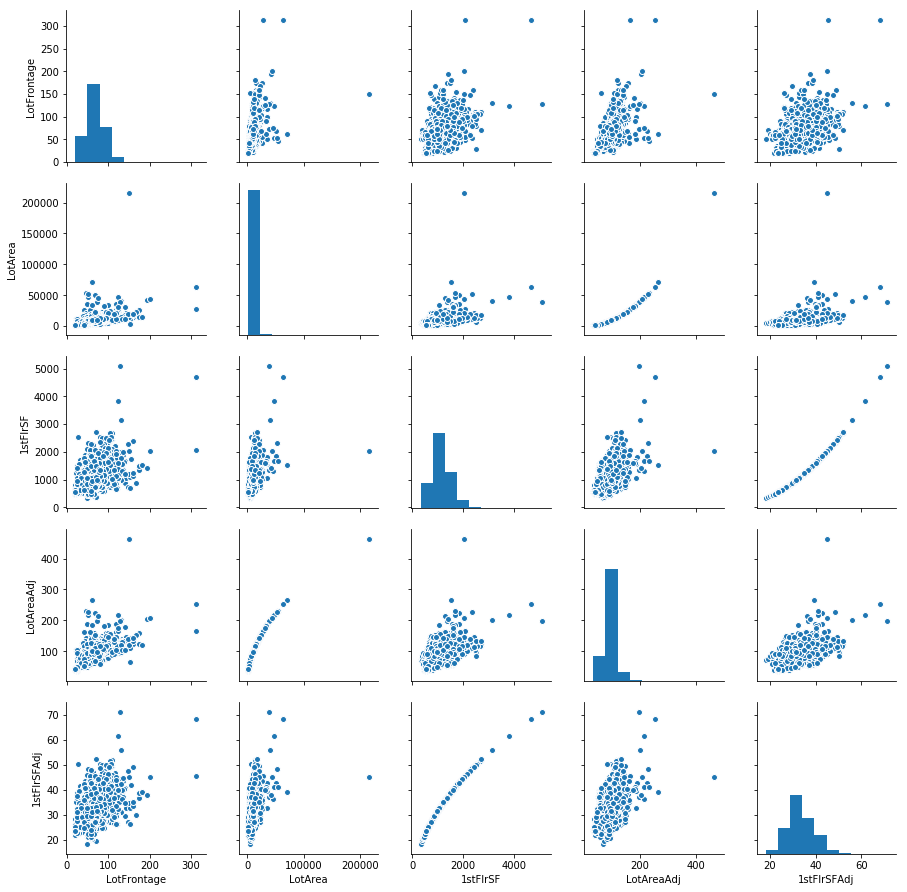

In [139]:
g = sns.pairplot(toy_data)

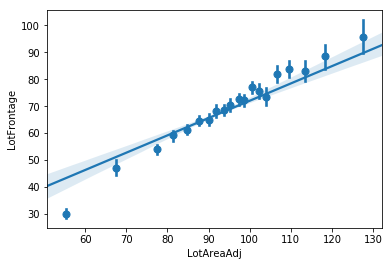

In [140]:
sns.regplot(x='LotAreaAdj', y='LotFrontage', data=toy_data, x_bins=20, logx=False)

In [141]:
full_data.groupby('LotShape').describe()['LotArea']

,count,mean,std,min,25%,50%,75%,max
LotShape,,,,,,,,
IR1,968.0,11620.964876,7832.758156,2403.0,8680.00,10531.5,12778.50,164660.0
IR2,76.0,18913.065789,22084.983651,4282.0,10985.75,13338.0,17278.50,159000.0
IR3,16.0,32064.187500,50768.258762,5232.0,12266.75,16211.0,23647.75,215245.0
Reg,1859.0,8865.632598,3900.239144,1300.0,7000.00,8777.0,10561.00,43500.0


In [142]:
full_data.groupby('LotConfig').describe()['LotArea']

,count,mean,std,min,25%,50%,75%,max
LotConfig,,,,,,,,
Corner,511.0,10843.315068,8236.550241,2308.0,8125.0,10284.0,12192.50,164660.0
CulDSac,176.0,15638.221591,15523.820219,1879.0,9699.5,12372.5,15700.25,159000.0
FR2,85.0,10595.976471,6799.824241,2280.0,6911.0,9600.0,12444.00,41600.0
FR3,14.0,10498.857143,4430.314937,3735.0,6912.0,9444.5,14250.00,16870.0
Inside,2133.0,9535.781528,6648.264274,1300.0,7200.0,9084.0,10950.00,215245.0


In [143]:
full_data.groupby('LandContour').describe()['LotArea']

,count,mean,std,min,25%,50%,75%,max
LandContour,,,,,,,,
Bnk,117.0,11377.102564,9618.277891,3000.0,7007.0,8737.0,11737.00,63887.0
HLS,120.0,12361.266667,15348.831916,1700.0,7184.0,11008.0,13680.50,164660.0
Low,60.0,26829.016667,35936.649355,2394.0,10038.0,14765.5,25023.75,215245.0
Lvl,2622.0,9632.536613,4297.087400,1300.0,7500.0,9375.0,11330.75,51974.0


In [144]:
full_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'Open

In [145]:
from sklearn.svm import SVR

In [146]:
full_data['LotAreaAdj'] = full_data['LotArea'] ** 0.5
full_data['1stFlrSFAdj'] = full_data['1stFlrSF'] ** 0.5

In [147]:
X_tr = full_data[full_data['LotFrontage'].isna() == False][['LotAreaAdj', '1stFlrSF']]
Y_tr = full_data[full_data['LotFrontage'].isna() == False]['LotFrontage']
X_te = full_data[full_data['LotFrontage'].isna()][['LotAreaAdj', '1stFlrSFAdj']]

In [148]:
#svr_params = {'kernel':['rbf', 'linear'], 'C': [0.1, 1, 5, 10, 100], 'gamma': [0.05, 0.1]}
#svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
#svr_regr = GridSearchCV(SVR(), svr_params, cv=10, scoring='neg_mean_squared_log_error')
#svr_regr.fit(X_tr, Y_tr)
#svr_regr.best_score_

In [151]:
full_data.drop(['LotAreaAdj', '1stFlrSF'], axis=1).fillna(-1).to_csv('full_clean_wo_LotFront.csv')

In [153]:
toy_data = pd.read_csv('full_clean_wo_LotFront.csv', index_col=0)
toy_data.shape

(2919, 78)

In [156]:
svr_params = {'kernel':['rbf'], 'C': [0.1, 1, 5, 10, 100], 'gamma': [0.05, 0.1]}
#svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_regr = GridSearchCV(SVR(), svr_params, cv=10, scoring='neg_mean_squared_log_error')
svr_regr.fit(X_tr, Y_tr)
svr_regr.best_score_

-0.07618708934316827

In [155]:
toy_data.isna().any().sum()

0

In [157]:
svr_regr.best_params_

{'C': 10, 'gamma': 0.05, 'kernel': 'rbf'}

In [168]:
LF_exist = full_data['LotFrontage'].isna() == False
y_pred = svr_regr.predict(full_data[['LotAreaAdj', '1stFlrSF']])
full_data['predict'] = y_pred
full_data['residual'] = 0
full_data.loc[LF_exist, ['residual']] = (full_data[LF_exist]['LotFrontage'] - full_data[LF_exist]['predict']) ** 2

<function matplotlib.pyplot.show(*args, **kw)>

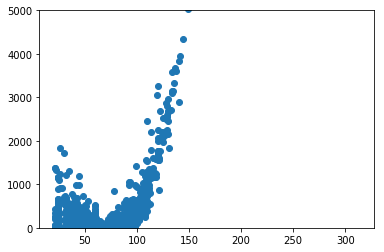

In [170]:
plt.scatter(full_data[LF_exist]['LotFrontage'], full_data[LF_exist]['residual'])
plt.ylim(0, 5000)
plt.show

In [171]:
full_data['LotFrontage'] = full_data.apply(
    lambda row: row['predict'] if np.isnan(row['LotFrontage']) else row['LotFrontage'], axis=1)

In [172]:
full_data.isna().any().sum()

0

In [173]:
full_data.drop(['LotAreaAdj', '1stFlrSF', 'predict', 'residual'], axis=1).to_csv('full_data_clean_1.csv')